# Practical 3: Probability of default (PD) prediction and credit rating analysis
<hr>
In this practice session, we consider the logistic regression model and study how it allows us to approach classification problems.


The notebook comprises demo codes, which you can execute, and small programming tasks. For some tasks, you might know the answer already. In that case, just code your solution and move on. More likely, however, you might come across a task for which you do not know immediately what is the solution and/or how to code it. This is the normal setting. In programming, we spent a lot of time on web searching for demos, tutorials or searching question-forums like *stackoverflow* to find a solution to a focal programming problem. Hence, whenever you do not know how to perform a task, try to find the answer on the internet. Web search is your friend!
Nowadays, as seen in our first practical, you can also get help from GenAI. Feel free to use GenAI for help when needed. However, whenever you use GenAI, make sure to carefully read the explanations that come with generated code. This allows you to learn and progress.

In [2]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Binary classification for PD modeling
The lecture introduced you to credit scoring, the problem of estimating the probability of credit applicants to repay debt.

For this demo, we consider the *Home Equity (HMEQ)* data set from the textbook [Credit Risk Analytics](http://www.creditriskanalytics.net). It comprises information about a set of borrowers, which are categorized along demographic features and features concerning their business relationship with the lender. A binary target variable called *BAD* is provided and indicates whether a borrower has repaid their debt. 


**Info:** our GitHub repo provides a much more comprehensive analysis of this data set in our demo of a [fully-fledged machine learning pipeline](https://github.com/stefanlessmann/ESMT_IML/blob/main/notebooks/demo_ml_pipeline.ipynb). You are welcome to take a look if interested.
 

### Loading and preparing the data
Using the `Pandas` library, we can retrieve the data right from the web; specifically the GitHub repository of this course. 

In [3]:
data_location = 'https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/master/data/hmeq.csv'
df = pd.read_csv(data_location)  # standard pandas function to load tabular data in CSV format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Here is an overview of the data:
- BAD: the target variable, 1=default; 0=non-default
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

As you can see, the features aim to describe the financial situation of a borrower, which should probably tell us something about the risk of a borrower to default.

Run the below code to obtain a snapshot of the data.

In [4]:
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


The data requires at least a little bit of preparation to be ready for machine learning. First, we need to address the missing values. Second, two of the features, REASON and JOB, are non-numeric. Such categorical features cannot be used in a logistic regression model. We must convert them to numbers before using them. The following code addresses both problems in a quick (but also simplistic) way.

In [5]:
# Convert a category with k different values into k-1 binary variables. 
X = pd.get_dummies(df, dummy_na=True, drop_first=True)
X = X.dropna().reset_index(drop=True)  # drop all cases with one or more missing value

# Separate the data into a matrix of feature values and a target variable
y = X.pop('BAD')

### Excercise 1: Plotting data for classification
You will remember the many plots we came across when discussing regression. We also saw some analog plots for classification problems in the lecture. One of them was a 2d scatter plot displaying the bi-variate relationship between selected features and the binary target variable. 

![Classification problem in 2D](https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/2d_classification_problem.png)

Your first task is to create a similar plot for the credit data. In principle, you can select any combination of features that you like.  

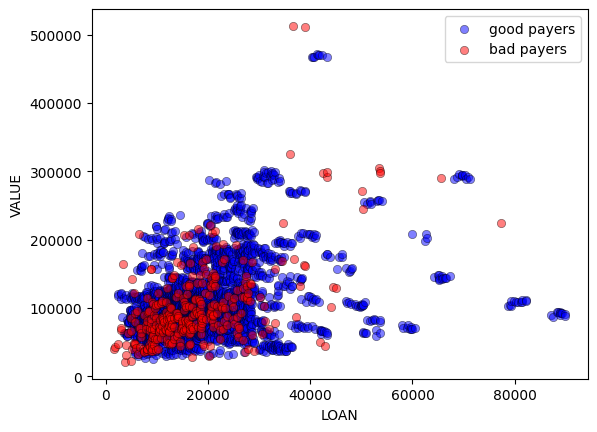

In [6]:
# Exercise 1
x1 = 'LOAN'  # select first feature of your choice
x2 = 'VALUE'  # select second feature of your choice

# Write code to create the scatter plot of x1 vs. x2. Make sure your plot shows the data points from different classes (good and bad payers) in different colors.
plt.scatter(X[y==0][x1], X[y==0][x2], c='blue', label="good payers", alpha=0.5, edgecolor="black", linewidth=0.5)
plt.scatter(X[y==1][x1], X[y==1][x2], c='red', label="bad payers", alpha=0.5, edgecolor="black", linewidth=0.5)
plt.legend(loc='best')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

For the sake of completeness, the lecture also introduced a different 2D plot, in which we chart the target variable against one of the features. Provided you have made a choice above, by assigning variable `x1` some valid feature name, you will be able to execute the below code to create this type of plot.

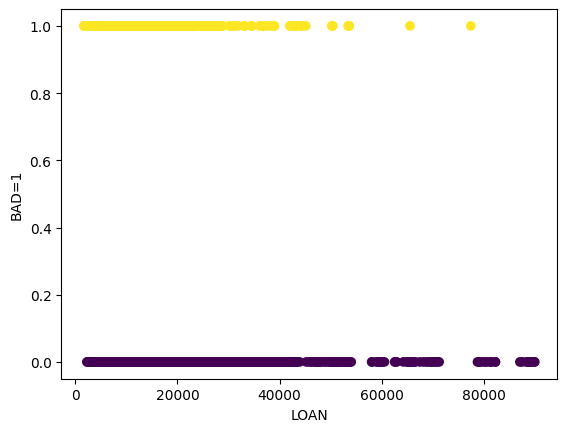

In [7]:
# Code to depict how the values of one feature, x1, distribute across the values of the target variable

# Just to make sure you did indeed a assign x1 a valid value ;)
assert x1 != '', "please assign a valid feature name to varible x2, like, e.g., x2='DEBTINC'"

# Plotting
plt.scatter(X[x1], y, c=y)
plt.xlabel(x1)
plt.ylabel('BAD=1')
plt.show()

## Logistic regression
Time to estimate our first model. We will use logistic regression. Think of it as an extension of linear regression for cases in which we work with a binary target variable. The lecture will soon provide more details.

Just as in linear regression, logistic regression involves model training on labelled data. The below code uses the `sklearn` library to train a logistic regression-based classification model. 

### Model training

In [8]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=888).fit(X, y)  # we define a random_state to ensure that we get the same results when re-running this cell multiple times
print(model)

LogisticRegression(random_state=888)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Note that the `sklearn` implementation does not provide an informative summary, as did the library `statsmodels` in our last practical. In brief, this is because `sklearn` is designed to support prediction. Let's demonstrate how to do this, that is compute predictions using the trained model. For simplicity, we compute prediction for the training data. You already learnt that this is inappropriate. We do it here to keep things simple. 

In [9]:
yhat = model.predict(X)  # simple way to compute predictions using logistic regression and any other machine learning model in sklearn 

Likely, you are also interested to assess the model. There is an easy way to do this:

In [10]:
perf = model.score(X, y)  # Call a general purpose evaluation function and obtain a (quality ) score of the model
print('Logit model achieves a score of {:.3f} %'.format(perf*100))

Logit model achieves a score of 91.010 %


### Exercise 2: Diagnosing predictions
A score of above 90 percent sounds very good. Actually, it is not, and your task is to find out why. Let's break it down into pieces.

#### A) What score?
Check the [sklearn documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) to understand what kind of score the function `score()` has provided. What is it that we see?

**Your answer:** By default, the score reported is the classification accuracy, which depends on a default classification cut-off of 0.5

#### B) Is it good or is it bad?
Interpreting our score will be easier if we compare it to a baseline. But what baseline? We face a classification problem. There are two classes, good payers and bad payers, and we aim to tell these apart. Come up with a very basic strategy to solve the classification problem without using any model. Write a piece of code to calculate the performance of your super-basic strategy. 
> Hint: if you feel a bit lost, consider web searching for *dummy classifier* 

In [11]:
# Code to calculate the score of a dummy classifier
pos_frac = np.sum(y==1)/len(y)  # share of the positive class, which typically represents the minority
print('A dummy classifier that always predicts the majority class, achieves classification accuracy equal to {:.2f}%'.format(100*(1-pos_frac)))

A dummy classifier that always predicts the majority class, achieves classification accuracy equal to 91.21%


If you succeeded with the previous task, you will have found that a super-basic - stupid - classifier does as well as logistic regression. This is a devastating result. Our logistic regression classifier is just as good as a naive classifier, which always predicts the majority class. Put differently, the logistic regression *appears* completely useless.

Note that our approach to compute the score of the naive classifier assumes that the positive class with $Y=1$ is the minority class. While this is typically the case, we should acknowledge that our approach is simplistic. It would be better to first establish which of the two classes is the majority class and to then use the fraction of that class as the accuracy score of a dummy classifier. While not too difficult, we leave this extension for the interested to perform and move on with probabilities. 

#### C) What about probabilities?
Exactly, what about probabilities? The lecture introduced classification as a machine learning setup aimed at predicting class membership probabilities. So logistic regression should answer questions such as "what is the estimated probability of the first credit applicant in our data set to repay?"

In [12]:
# Write code to print the prediction of logistic regression for the first data point in our matrix X
yhat = model.predict(X)
print(yhat[0])

0


Solving the above task, you will find that the prediction does not look like a probability. Examine this point in more detail. To that end, write code that tells you what *distinct* values logistic regression predicts. Put differently, your code should print out all unique values that logistic regression has predicted across all data points. 

Briefly explain your result.

In [13]:
# Code to find out the distinct values of the predictions
np.unique(yhat)

array([0, 1])

**What is the meaning of the predictions? Briefly explain.**

So the function `predict()` produces discrete class predictions. It outputs only the values with which the classes were encoded, that is either zero for class *good payer* or 1 for class *bad payer*. However, as shown using the function `numpy.unique()`, our logisitic regression only predicts class 0 and never predicts class 1.

Finally, we come back to the innocent question asked before, "what is the estimated probability of the first credit applicant in our data set to repay?". Given our previous analysis has not answered this question it is about time to. Write code to find out the estimated probability of the first applicant to be a bad credit risk?

Just in case, mathematically, we could represent the sought probability as $\hat{p}(BAD==1|X_1)$.

In [14]:
# Code to obtain probability predictions from the logit model
yhat_prob = model.predict_proba(X)
yhat_prob[0:5]

array([[0.67962276, 0.32037724],
       [0.67619689, 0.32380311],
       [0.7239294 , 0.2760706 ],
       [0.6993553 , 0.3006447 ],
       [0.75264799, 0.24735201]])

### Visualizing the logistic regression

#### Exercise 3: One more logistic regression
Please estimate a second logistic regression model. This time, use only two features. Exercise 1 has asked you to examine combinations of features. Just continue with the two features you selected there. 

In [15]:
print('Our first feature is:\t', x1)
print('Our second feature is:\t', x2)

Our first feature is:	 LOAN
Our second feature is:	 VALUE


In [16]:
# Write code to estimate a logistic regression classifier using only the two above features
model2 = LogisticRegression(random_state=888).fit(X[[x1, x2]], y)

#### The visual logistic regression
As you will have guessed, the point of the above exercise 4 was only to obtain a logistic regression model that we can plot; hence the need to select two features. 
The visualization is somewhat complex. Thus, all code is readily available for you. Below we provide a function `plot_logit_decision_surface()`. 
**Do not be put off by the length of the code.** You are not supposed to look through the function at this point. Of course you can, but do not allow it to confuse you. It is a function to create a plot. That is all you need to know for now. Please execute the cell to make sure you can use the function in the next exercise. 

In [17]:
def plot_logit_decision_surface(model, data, x1, x2, save_fig=False):
    '''
        Visualization of logistic regression in 2D
        
        Creates a plot depicting the distribution of the input
        data along two dimensions and the probability predictions
        of a logistic regression model. 

        Parameters
        ----------
        model :   An instance of the sklearn class LogisticRegression,  which        
                  has been trained on the input data.

        data  :   Pandas data frame providing the feature values.

        x1, x2:   The function plots the results of logistic regression in
                  two dimensions. The parameters x1 and x2 give the names
                  of the features used for plotting. These features will be
                  extracted from the data frame.

        save_fig: Binary variable allowing you to save the figure as a PNG image. 
                  Default: False

        Returns
        ----------
        The function does not return a result. It's purpose is to visualize 
        logistic regression model. The corresponding plot is the only output.
    '''

    #if len(model.coef_.ravel())!=2:
    #    raise Exception('Please estimate a logit model using only two features!')
    # Define some variables to govern the plot
    bounds = data.describe().loc[["min", "max"]][[x1, x2]].to_numpy()  # value ranges of the two features
    eps = 5  # tolerance parameter 

    # Create hypothetical data points spanning the entire range of feature values.
    # We need these to get from our logistic regression model a probability prediction
    # for every possible data point
    xx, yy = np.mgrid[(bounds[0,0]-eps):(bounds[1,0]+eps), (bounds[0,1]-eps):(bounds[1,1]+eps)]
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Perhaps the logistic regression model was fitted using the full data frame. 
    # To also work in that case, we extract the estimated regression coefficients 
    # corresponding to the two features we consider for plotting
    feature_to_index = {name: idx for idx, name in enumerate(model.feature_names_in_)}  # create a dic as intermediate step
    indices = [feature_to_index[f] for f in [x1, x2]]  # Find the indices of our two features of interest using the dic
    w = model.coef_.ravel()[indices]  # estimated regression coefficients
    b = model.intercept_  # estimated intercept of the logistic regression model

    # Compute probability predictions over the entire space of possible feature values
    # In the interest of robustness, we manually compute the logistic regression predictions
    # using the regression coefficients extracted above
    probs = 1/(1+np.exp(-(np.dot(grid, w.reshape(2,-1))+b))).reshape(xx.shape)

    # We are finally ready to create our visualization
    f, ax = plt.subplots(figsize=(8, 6))  # new figure
    # Contour plot of the probability predictions across the entire feature range
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)  
    ax_c = f.colorbar(contour)
    ax_c.set_label("$\hat{p}(y=1|X)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    # Scatter plot of the actual data
    ax.scatter(data[x1], data[x2], c=y, s=50, cmap="RdBu", vmin=0, vmax=1,
               edgecolor="white", linewidth=1);
    plt.xlabel(x1)
    plt.ylabel(x2)
    if save_fig==True:
        plt.savefig('logit_contour.png')
    plt.show()

<>:60: SyntaxWarning: invalid escape sequence '\h'
<>:60: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_50395/3748774087.py:60: SyntaxWarning: invalid escape sequence '\h'
  ax_c.set_label("$\hat{p}(y=1|X)$")


#### Exercise 4: Surface plot
We are almost ready. Also run the next cell, which will give you some instructions on how to use the plotting function. Note that this code also works for other functions. Just put a '?' in front of a function call and run the code. 

In [18]:
help(plot_logit_decision_surface)

Help on function plot_logit_decision_surface in module __main__:

plot_logit_decision_surface(model, data, x1, x2, save_fig=False)
    Visualization of logistic regression in 2D

    Creates a plot depicting the distribution of the input
    data along two dimensions and the probability predictions
    of a logistic regression model.

    Parameters
    ----------
    model :   An instance of the sklearn class LogisticRegression,  which
              has been trained on the input data.

    data  :   Pandas data frame providing the feature values.

    x1, x2:   The function plots the results of logistic regression in
              two dimensions. The parameters x1 and x2 give the names
              of the features used for plotting. These features will be
              extracted from the data frame.

    save_fig: Binary variable allowing you to save the figure as a PNG image.
              Default: False

    Returns
    ----------
    The function does not return a result. It's pur

I guess your next task is obvious. Write code to call the function providing the necessary parameters so that it can do its job. If used correctly, the function will create a plot like this one:
![Contour plot of logistic regression model](https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/logit_contour.png)

Let's if it works for you...

In [19]:
# Code to call the function plot_logit_decision_surface()
plot_logit_decision_surface(model2, X, x1, x2)

/tmp/ipykernel_50395/3748774087.py:60: SyntaxWarning: invalid escape sequence '\h'
  ax_c.set_label("$\hat{p}(y=1|X)$")


MemoryError: Unable to allocate 646. GiB for an array with shape (2, 88210, 491516) and data type float64

Finally, and hoping you got a nice contour plot of your logistic regression model, it is time to pause and think about the plot. It tells you a lot about how logistic regression works and the output you obtain. This is something we need to discuss in class. 

# Well done! This was another comprehensive set of exercises.